# Using historic NYC taxi data to predict the length of taxi rides in Manhattan

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [2]:
import sqlite3

conn = sqlite3.connect('taxi.db')
lon_bounds = [-74.03, -73.75]
lat_bounds = [40.6, 40.88]
cols = ['dropoff_lon','pickup_lon','dropoff_lat','pickup_lat']

all_taxi = pd.read_sql_query("SELECT * FROM taxi;",conn)
for i in range(4):
    if i < 2:
        all_taxi = all_taxi[(all_taxi[cols[i]] >= lon_bounds[0]) & (all_taxi[cols[i]] <= lon_bounds[1])]
    else:
        all_taxi = all_taxi[(all_taxi[cols[i]] >= lat_bounds[0]) & (all_taxi[cols[i]] <= lat_bounds[1])]
all_taxi.head()

,pickup_datetime,dropoff_datetime,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat,passengers,distance,duration
0,2016-01-30 22:47:32,2016-01-30 23:03:53,-73.988251,40.743542,-74.015251,40.709808,1,3.99,981
1,2016-01-04 04:30:48,2016-01-04 04:36:08,-73.995888,40.760010,-73.975388,40.782200,1,2.03,320
2,2016-01-07 21:52:24,2016-01-07 21:57:23,-73.990440,40.730469,-73.985542,40.738510,1,0.70,299
3,2016-01-01 04:13:41,2016-01-01 04:19:24,-73.944725,40.714539,-73.955421,40.719173,1,0.80,343
4,2016-01-08 18:46:10,2016-01-08 18:54:00,-74.004494,40.706989,-74.010155,40.716751,5,0.97,470


First we look at all the pickup locations, we are going to focus on only manhattan pickups and dropoffs, but we want to see what all the data look like first.

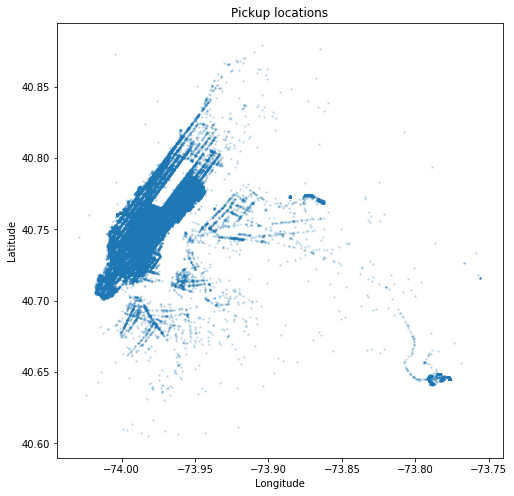

In [3]:
def pickup_scatter(t):
    plt.scatter(t['pickup_lon'], t['pickup_lat'], s=2, alpha=0.2)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Pickup locations')
    
plt.figure(figsize=(8, 8))
pickup_scatter(all_taxi)

Clearly the bulk of the traffic is within Manhattan, but there are clusters of pickups at each of the airports. If we were to include these, the predictor would be pretty skewed towards these much longer trips.

## Data Cleaning

Making sure the trips have:

1) Positive passenger count

2) Positive distance

3) Trips that are between 1 and 60 minutes in length

4) Average speed at most 100mph

In [4]:
clean_taxi = (all_taxi[(all_taxi.passengers > 0) & (all_taxi.distance >0) & (all_taxi.duration >= 60) 
    & (all_taxi.duration <= 3600) & ((all_taxi.distance.values / all_taxi.duration.values)*3600 <= 100)])
clean_taxi.head()

C:\Users\alexc\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


,pickup_datetime,dropoff_datetime,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat,passengers,distance,duration
0,2016-01-30 22:47:32,2016-01-30 23:03:53,-73.988251,40.743542,-74.015251,40.709808,1,3.99,981
1,2016-01-04 04:30:48,2016-01-04 04:36:08,-73.995888,40.760010,-73.975388,40.782200,1,2.03,320
2,2016-01-07 21:52:24,2016-01-07 21:57:23,-73.990440,40.730469,-73.985542,40.738510,1,0.70,299
3,2016-01-01 04:13:41,2016-01-01 04:19:24,-73.944725,40.714539,-73.955421,40.719173,1,0.80,343
4,2016-01-08 18:46:10,2016-01-08 18:54:00,-74.004494,40.706989,-74.010155,40.716751,5,0.97,470


Using the Excel spreadsheet with the longitude and latitude of the vertices of the polygon which defines Manhattan, we can limit the clean data to that which has pickups and dropoffs only within the polygon.

In [6]:
polygon = pd.read_csv('manhattan.csv')

lats,lons = polygon.lat.values,polygon.lon.values
corners = len(polygon)
def in_manhattan(x, y):
    """Whether a longitude-latitude (x, y) pair is in the Manhattan polygon."""
    odd_nodes = False
    j = corners - 1
    for i in range(corners):
        if ((lats[i] < y and lats[j] >= y
        or lats[j] < y and lats[i] >= y) 
        and (lons[i] <= x or lons[j] <= x)):
            if lons[i] + (y-lats[i])/(lats[j]-lats[i])*(lons[j]-lons[i]) < x:
                odd_nodes = not odd_nodes
        j=i;
    return odd_nodes
clean_copy = clean_taxi.copy()
clean_taxi['pickup_man'] = np.vectorize(in_manhattan)(clean_taxi.pickup_lon,clean_taxi.pickup_lat)
clean_taxi['dropoff_man'] = np.vectorize(in_manhattan)(clean_taxi.dropoff_lon,clean_taxi.dropoff_lat)
manhattan_taxi = clean_taxi[(clean_taxi.pickup_man == True) & (clean_taxi.dropoff_man == True)]
manhattan_taxi.drop(columns=['pickup_man','dropoff_man'],inplace=True)

C:\Users\alexc\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\alexc\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Now we can see what of the original pickup scatter plot is left

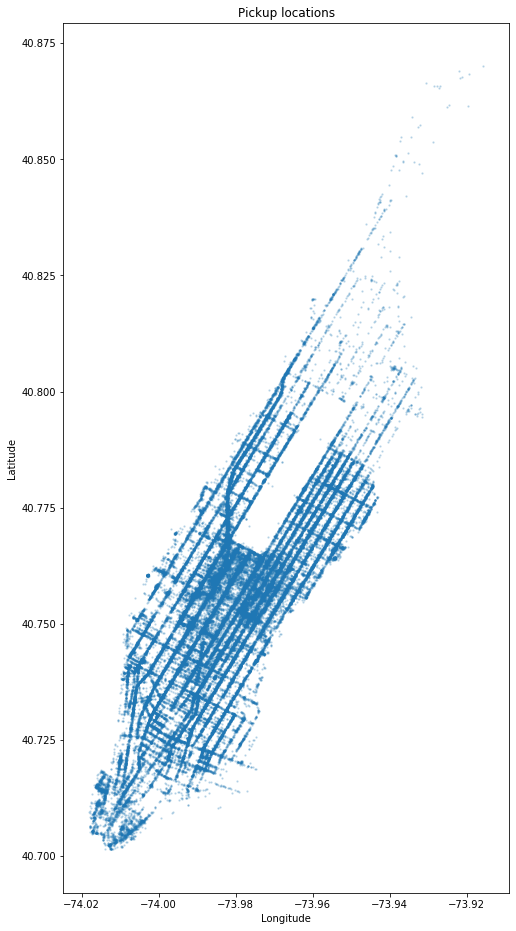

In [8]:
plt.figure(figsize=(8, 16))
pickup_scatter(manhattan_taxi)

In [9]:
print('Of the original', len(all_taxi),'trips,', len(all_taxi)-len(clean_taxi), 'were removed through data cleaning.' \
      '\nOf the remaining,', len(clean_taxi),'trips,',len(manhattan_taxi),'were within Manhattan and are kept for analysis.'
     )

Of the original 97692 trips, 1247 were removed through data cleaning.
Of the remaining, 96445 trips, 82800 were within Manhattan and are kept for analysis.


# EDA

In [10]:
from datetime import datetime
manhattan_taxi['date'] = manhattan_taxi.pickup_datetime.apply(lambda x: datetime.strptime(x[0:10],'%Y-%m-%d'))
manhattan_taxi.head()

C:\Users\alexc\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,pickup_datetime,dropoff_datetime,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat,passengers,distance,duration,date
0,2016-01-30 22:47:32,2016-01-30 23:03:53,-73.988251,40.743542,-74.015251,40.709808,1,3.99,981,2016-01-30
1,2016-01-04 04:30:48,2016-01-04 04:36:08,-73.995888,40.760010,-73.975388,40.782200,1,2.03,320,2016-01-04
2,2016-01-07 21:52:24,2016-01-07 21:57:23,-73.990440,40.730469,-73.985542,40.738510,1,0.70,299,2016-01-07
4,2016-01-08 18:46:10,2016-01-08 18:54:00,-74.004494,40.706989,-74.010155,40.716751,5,0.97,470,2016-01-08
5,2016-01-02 12:39:57,2016-01-02 12:53:29,-73.958214,40.760525,-73.983360,40.760406,1,1.70,812,2016-01-02


The data we are using is from 2016, and there was an historically large blizzard that month. Since we want this predictor to be generalizable, we certainly want to avoid using days which could be considered outliers for their level of taxi use. 

First we figure out which of these days should be removed:

C:\Users\alexc\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


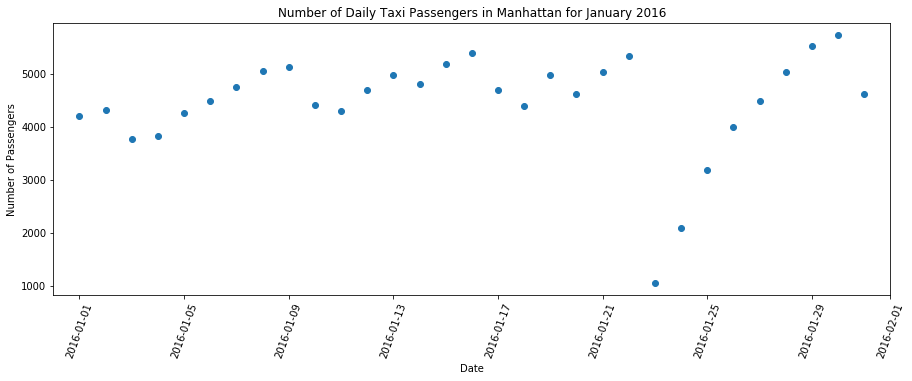

In [11]:
plt.figure(figsize=(15,5))
plt.scatter(x=manhattan_taxi.groupby('date').agg(sum).index,y=manhattan_taxi.groupby('date').agg(sum).passengers)
plt.xticks(rotation=70)
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.title('Number of Daily Taxi Passengers in Manhattan for January 2016')
plt.xlim(['2015-12-31','2016-02-01'])
plt.show();

In [12]:
from datetime import date

atypical = [1, 2, 3, 18, 23, 24, 25, 26]
typical_dates = [date(2016, 1, n) for n in range(1, 32) if n not in atypical]
typical_dates
final_taxi = manhattan_taxi[manhattan_taxi['date'].isin(typical_dates)]

# Feature Engineering

In [14]:
#Train Test Split
import sklearn.model_selection

train, test = sklearn.model_selection.train_test_split(
    final_taxi, train_size=0.8, test_size=0.2, random_state=42)
print('Train:', train.shape, 'Test:', test.shape)

Train: (53680, 10) Test: (13421, 10)


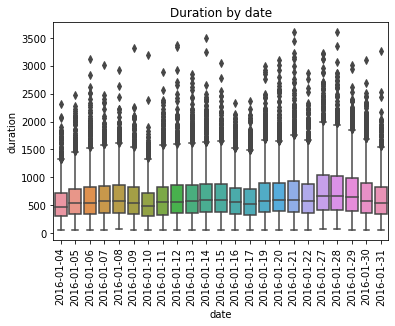

In [15]:
ax = sns.boxplot(data=train,x='date',y='duration')
ax.set_xticklabels(typical_dates)
plt.xticks(rotation=90)
plt.xlabel('date')
plt.ylabel('duration')
plt.title('Duration by date')
plt.show();

The features will be start location, end location, trip distance, time of day, and day of week. We will have to add some additional columns in order to do use all these features.

In [19]:
def speed(t):
    return t['distance'] / t['duration'] * 60 * 60

def augment(t):
    u = t.copy()
    pickup_time = pd.to_datetime(t['pickup_datetime'])
    u.loc[:, 'hour'] = pickup_time.dt.hour
    u.loc[:, 'day'] = pickup_time.dt.weekday
    u.loc[:, 'weekend'] = (pickup_time.dt.weekday >= 5).astype(int)
    u.loc[:, 'period'] = np.digitize(pickup_time.dt.hour, [0, 6, 18])
    u.loc[:, 'speed'] = speed(t)
    return u
    
train = augment(train)
test = augment(test)

Splitting the data into early morning (12am-6am), day (6am-6pm), and night (6pm-12am) may be a good way to encode time of day beyond simply the hour, if there is a difference in these average speeds. 

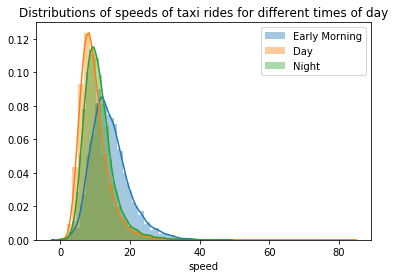

In [17]:
sns.distplot(a=train[(train.hour >=0) & (train.hour <6)].speed,label='Early Morning')
sns.distplot(a=train[(train.hour >= 6) & (train.hour <18)].speed,label='Day')
sns.distplot(a=train[(train.hour>=18) & (train.hour <23.9)].speed,label='Night')
plt.title('Distributions of speeds of taxi rides for different times of day')
plt.legend()

Additionally, dividing Manhattan into its three parts (Lower, Midtown, and Upper) could be a simple way to determine pickup and dropoff locations; using principal component analysis (PCA) makes this straightforward.

In [21]:
D = train[['pickup_lon','pickup_lat']]
pca_n = D.shape[0]
pca_means = np.average(D,axis=0)
X = (D - pca_means) / np.sqrt(pca_n)
u, s, vt = np.linalg.svd(X, full_matrices=False)

def add_region(t):
    D = t[['pickup_lon','pickup_lat']]
    X = (D - pca_means) / np.sqrt(pca_n) 
    first_pc = X @ np.transpose(vt[0:2,:])[:,0]
    t.loc[:,'region'] = pd.qcut(first_pc, 3, labels=[0, 1, 2])
    
add_region(train)
add_region(test)

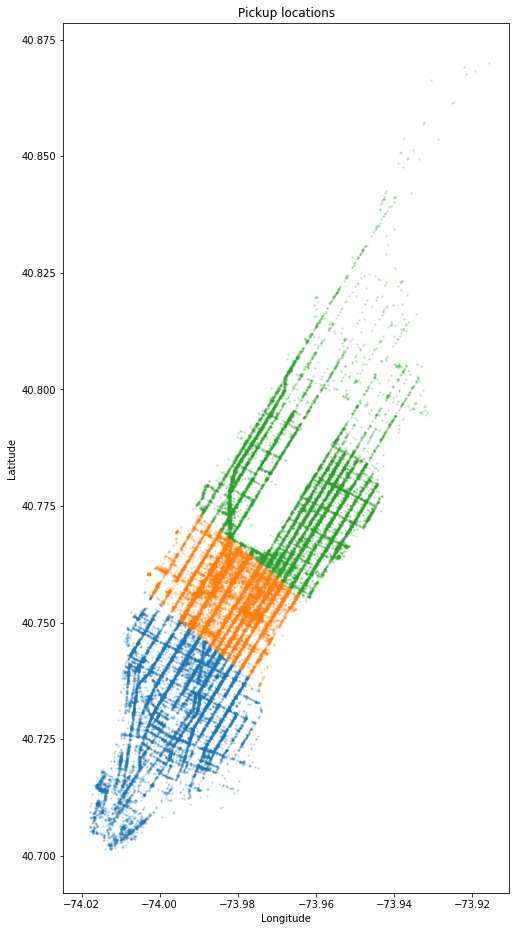

In [22]:
plt.figure(figsize=(8, 16))
for i in [0, 1, 2]:
    pickup_scatter(train[train['region'] == i])

And we can see that there is a pretty well approximated seperation of the three regions

So now we can see how the average speeds for the different times of day is different for each of the three regions

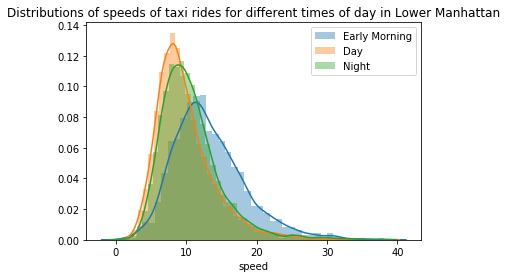

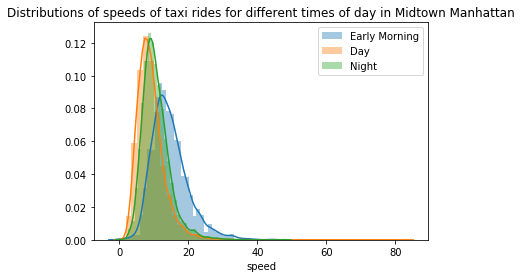

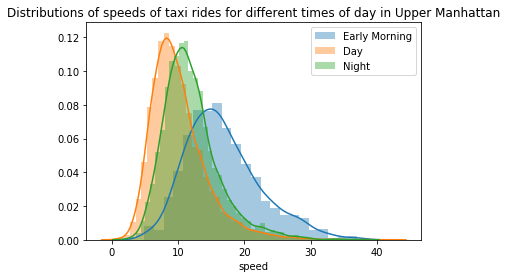

In [23]:
regions = ['Lower','Midtown','Upper']
for i in range(3):
    plt.figure(i)
    sns.distplot(a=train[(train.hour >=0) & (train.hour <6) & (train.region == i)].speed,label='Early Morning')
    sns.distplot(a=train[(train.hour >= 6) & (train.hour <18)& (train.region == i)].speed,label='Day')
    sns.distplot(a=train[(train.hour>=18) & (train.hour <23.9)& (train.region == i)].speed,label='Night')
    plt.title('Distributions of speeds of taxi rides for different times of day in '+ regions[i] + ' Manhattan')
    plt.legend()
    plt.show();

Finally we are ready to build the design matrix which includes all the different features

In [25]:
from sklearn.preprocessing import StandardScaler

num_vars = ['pickup_lon', 'pickup_lat', 'dropoff_lon', 'dropoff_lat', 'distance']
cat_vars = ['hour', 'day', 'region']

scaler = StandardScaler()
scaler.fit(train[num_vars])

def design_matrix(t):
    """Create a design matrix from taxi ride dataframe t."""
    scaled = t[num_vars].copy()
    scaled.iloc[:,:] = scaler.transform(scaled) # Convert to standard units
    categoricals = [pd.get_dummies(t[s], prefix=s, drop_first=True) for s in cat_vars]
    return pd.concat([scaled] + categoricals, axis=1)

## Now we can examine how different models perform

1. Constant model

In [26]:
def rmse(errors):
    """Return the root mean squared error."""
    return np.sqrt(np.mean(errors ** 2))

constant_rmse = rmse(test.duration.values-np.mean(train.duration.values))
constant_rmse

399.1437572352666

2. linear regression (using only the distance as a predictor)

In [27]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(train.distance.values.reshape(-1,1),train.duration.values)
simple_rmse = rmse(test.duration.values-model.predict(test.distance.values.reshape(-1,1)))
simple_rmse

276.7841105000342

3. linear regression (fitted to training set without regularization, using our design matrix)

In [28]:
model = LinearRegression()
model.fit(design_matrix(train),train.duration)
linear_rmse = rmse(test.duration-model.predict(design_matrix(test)))
linear_rmse

255.19146631882765

4. For each value of period, we fit an unregularized linear regression to the training set with that period. Then a model chooses regression parameters based off the rmse from each period.

In [29]:
model = LinearRegression()
errors = []

for v in np.unique(train['period']):
    model.fit(design_matrix(train[train.period==v]),train[train.period==v].duration)
    errors.append(test[test.period==v].duration.values-model.predict(design_matrix(test[test.period==v])))
    
period_rmse = rmse(np.concatenate(errors).ravel())
period_rmse

246.62868831165176

5. Instead of predicting duration directly, predict average speed of the entire ride and use that to compute duration. 

In [30]:
speed_model = LinearRegression()
model.fit(design_matrix(train),train.speed)

speed_rmse = rmse(test.duration-test.distance/model.predict(design_matrix(test))*3600)
speed_rmse

243.01798368514966

6. Lastly we wil combine these different ideas to build a model

The model:

- Uses a different linear regression for each combination of variables in `choices`

- - Fit to the specified `outcome` (either `'duration'` or `'speed'`) and predict that `outcome` (on test) for each combination 

- Uses the specified either `duration_error` or `speed_error` to compute the error in predicted duration using the predicted outcome

- Aggregates those errors over the whole test set

In [31]:
model = LinearRegression()
choices = ['period', 'region', 'weekend']

def duration_error(predictions, observations):
    """Error between predictions (array) and observations (data frame)"""
    return predictions - observations['duration']

def speed_error(predictions, observations):
    """Duration error between speed predictions and duration observations"""
    return observations['distance']/predictions*3600 - observations['duration']

def tree_regression_errors(outcome='duration', error_fn=duration_error):
    """Return errors for all examples in test using a tree regression model."""
    errors = []
    for vs in train.groupby(choices).size().index:
        v_train, v_test = train, test
        for v, c in zip(vs, choices):
            v_train = v_train[v_train[c] == v]
            v_test = v_test[v_test[c]==v]
        model.fit(design_matrix(v_train),v_train[outcome])
        errors.append(error_fn(model.predict(design_matrix(v_test)),v_test))
    return errors

errors = tree_regression_errors()
errors_via_speed = tree_regression_errors('speed', speed_error)
tree_rmse = rmse(np.concatenate(errors).ravel())
tree_speed_rmse = rmse(np.concatenate(errors_via_speed).ravel())
print('Duration:', tree_rmse, '\nSpeed:', tree_speed_rmse)

Duration: 240.3395219270353 
Speed: 226.90793945018308


For a summary of the different methods:

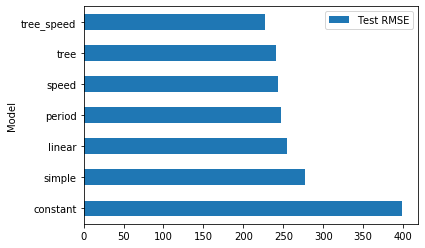

In [32]:
models = ['constant', 'simple', 'linear', 'period', 'speed', 'tree', 'tree_speed']
pd.DataFrame.from_dict({
    'Model': models,
    'Test RMSE': [eval(m + '_rmse') for m in models]
}).set_index('Model').plot(kind='barh');